In [1]:
# Run this cell first

!git clone https://github.com/Mlodko/reed-solomon.git
%cd reed-solomon

/content/reed-solomon


In [3]:
# Install and test rich output
%pip install rich

In [2]:
from rs import RSCoder, binary_format
from rich.console import Console
from rich.text import Text
import math
import random
import sys

COLOR_BG = "plum2"
COLOR_PAD = "bright_black"
COLOR_MSG = "green"
COLOR_PARITY = "steel_blue"
STYLE_COMMON = f"bold on {COLOR_BG}"
COLOR_CHECK_OK = "bright_green bold"
COLOR_CHECK_FAIL = "red bold"
COLOR_ERROR = "bold red"


n = 255  # @param {type:"slider", min:1, max:255, step:1}
k = 223  # @param {type:"slider", min:1, max:254, step:1}
input = "  Lorem ipsum dolor sit amet, consectetur adipiscing elit. Phasellus euismod vehicula felis, ac porta lectus eleifend a. Praesent mauris orci, hendrerit non odio eget, interdum placerat enim. Maecenas ante purus, tempor et vulputate ut, dignissim quis ante. Etiam sollicitudin mattis justo in bibendum. Nam arcu erat, lobortis eget quam vitae, aliquet ullamcorper turpis. Mauris a elit vitae nunc porttitor commodo vitae ut sem. Praesent tristique enim et scelerisque lobortis. Curabitur luctus imperdiet libero, et malesuada sem tincidunt vel. Sed a dui justo.  Maecenas tempor neque nibh, ut tempus augue malesuada a."  # @param {type:"string", placeholder:"Enter a message to be encoded"}
errors_per_block = 17 # @param {type:"slider", min:0, max:255, step:1}


def introduce_errors(encoded_blocks, errors_per_block=2):
    """Introduces errors while avoiding problematic field values."""
    corrupted_blocks = []
    all_error_positions = []

    # Avoid values that would create field elements without inverses
    SAFE_ERROR_VALUES = [1, 2, 3, 4, 5]

    for block in encoded_blocks:
        block_chars = list(block)
        error_positions = random.sample(range(len(block_chars)), min(errors_per_block, len(block_chars)))
        all_error_positions.append(error_positions)

        for pos in error_positions:
            current_val = ord(block_chars[pos])
            # Make sure we avoid creating value 255
            while True:
                error_val = random.choice(SAFE_ERROR_VALUES)
                if (current_val + error_val) % 256 != 255:
                    break

            block_chars[pos] = chr((current_val + error_val) % 256)

        corrupted_blocks.append(''.join(block_chars))

    return corrupted_blocks, all_error_positions

def binary_format_highlighted(data, error_positions=None):
    """Create a formatted hex representation with optional error highlighting."""
    bytes_array = [ord(c) for c in data]
    binary_strings = []

    for i, byte in enumerate(bytes_array):
        if error_positions and i in error_positions:
            binary_strings.append(f"ERROR:{format(byte, '02X')}")
        else:
            binary_strings.append(format(byte, '02X'))

    rows = []
    for i in range(0, len(binary_strings), 16):
        row = binary_strings[i:i+16]
        rows.append(' '.join(row))

    return '\n'.join(rows)

def print_highlighted_binary(binary_str, console):
    """Prints binary representation with error highlighting."""
    text = Text()
    lines = binary_str.strip().splitlines()

    for line in lines:
        tokens = line.split()
        for i, token in enumerate(tokens):
            if token.startswith("ERROR:"):
                text.append(token[6:], COLOR_ERROR)
            else:
                text.append(token)

            if i < len(tokens) - 1:
                text.append(" ")

        if line != lines[-1]:
            text.append("\n")

    console.print(text)

coder = RSCoder(n, k)
console = Console(highlight=False)

input_char_length = len(input)
input_blocks = [input[i:i + k] for i in range(0, input_char_length, k)]

encoded_blocks = [coder.encode(block) for block in input_blocks]

encoded_blocks_corrupted, error_positions = introduce_errors(encoded_blocks, errors_per_block)

decoded_blocks = []
for i, encoded_block in enumerate(encoded_blocks_corrupted):
    decoded_block = coder.decode(bytes(encoded_block, 'latin1'))
    decoded_blocks.append(decoded_block[:len(input_blocks[i])])

decoded = ''.join(decoded_blocks)

bin_input = binary_format(input)
bin_decoded = binary_format(decoded)
bin_input_blocks = [binary_format(block) for block in input_blocks]
bin_encoded_blocks = [binary_format(block) for block in encoded_blocks_corrupted]

highlighted_blocks = []

for block, encoded_block in zip(input_blocks, encoded_blocks):
    pad_len = k - len(block)
    byte_lines = binary_format(encoded_block).strip().splitlines()
    byte_tokens = [b for line in byte_lines for b in line.strip().split()]

    text = Text()

    for i, byte in enumerate(byte_tokens):
        if i < pad_len:
            style = f"{COLOR_PAD} {STYLE_COMMON}"
        elif i < k:
            style = f"{COLOR_MSG} {STYLE_COMMON}"
        else:
            style = f"{COLOR_PARITY} {STYLE_COMMON}"

        text.append(byte, style)
        text.append(" " if (i + 1) % 16 else "\n", f"on {COLOR_BG}")

    highlighted_blocks.append(text)

bin_input_pretty = Text(bin_input)
bin_input_pretty.stylize(f"{COLOR_MSG} bold", 0, len(bin_input))

bin_decoded_pretty = Text(bin_decoded)
start = bin_decoded.find(bin_input)
if start != -1:
    bin_decoded_pretty.stylize(f"{COLOR_MSG} bold", start, start + len(bin_input))

block_count = math.ceil(input_char_length / k)
encoded_char_length = block_count * n
padding_char_length = block_count * k - input_char_length
parity_char_length = block_count * (n - k)

console.print("\n===============================================")
console.print("DECODING RESULTS:")
console.print("===============================================")

console.print("\nUnencoded message:\n\tBinary representation:")
console.print(bin_input_pretty)
console.print(f"Character (byte) length: {input_char_length}")

console.print("\n=========================================\n")
console.print("Encoded message:\n\tBinary representation:")
for block in highlighted_blocks:
    console.print(block + "\n")


console.print(f"Total byte length (block_count × n): [{COLOR_BG}]{encoded_char_length}[/{COLOR_BG}]")
console.print(f"Padding byte length (block_count × k - input_chars): [{COLOR_PAD}]{padding_char_length}[/{COLOR_PAD}]")
console.print(f"Message byte length: [{COLOR_MSG}]{input_char_length}[/{COLOR_MSG}]")
console.print(f"Parity byte length (block_count × (n - k)): [{COLOR_PARITY}]{parity_char_length}[/{COLOR_PARITY}]")

console.print("\n===============================================")
console.print("Corrupted message (errors in red):")
for i, (block, positions) in enumerate(zip(encoded_blocks_corrupted, error_positions)):
    highlighted_binary = binary_format_highlighted(block, positions)
    print_highlighted_binary(highlighted_binary, console)

console.print("\n=========================================\n")
console.print("Decoded message:\n\tBinary representation:")
console.print(bin_decoded_pretty)

console.print("\n=========================================\n")
console.print("Decoding validity check:")
if decoded == input:
  console.print(f"[{COLOR_CHECK_OK}]✓ [OK] Decoded message matches input[/{COLOR_CHECK_OK}]")
else:
    console.print(f"[{COLOR_CHECK_FAIL}]✗ [FAIL] Decoded message doesn't match input[/{COLOR_CHECK_FAIL}]")
    console.print(f"\tInput message: {input}\n\tDecoded message: {decoded}")


===============================================

DECODING RESULTS:

===============================================

Unencoded message:
        Binary representation:

20 20 4C 6F 72 65 6D 20 69 70 73 75 6D 20 64 6F
6C 6F 72 20 73 69 74 20 61 6D 65 74 2C 20 63 6F
6E 73 65 63 74 65 74 75 72 20 61 64 69 70 69 73
63 69 6E 67 20 65 6C 69 74 2E 20 50 68 61 73 65
6C 6C 75 73 20 65 75 69 73 6D 6F 64 20 76 65 68
69 63 75 6C 61 20 66 65 6C 69 73 2C 20 61 63 20
70 6F 72 74 61 20 6C 65 63 74 75 73 20 65 6C 65
69 66 65 6E 64 20 61 2E 20 50 72 61 65 73 65 6E
74 20 6D 61 75 72 69 73 20 6F 72 63 69 2C 20 68
65 6E 64 72 65 72 69 74 20 6E 6F 6E 20 6F 64 69
6F 20 65 67 65 74 2C 20 69 6E 74 65 72 64 75 6D
20 70 6C 61 63 65 72 61 74 20 65 6E 69 6D 2E 20
4D 61 65 63 65 6E 61 73 20 61 6E 74 65 20 70 75
72 75 73 2C 20 74 65 6D 70 6F 72 20 65 74 20 76
75 6C 70 75 74 61 74 65 20 75 74 2C 20 64 69 67
6E 69 73 73 69 6D 20 71 75 69 73 20 61 6E 74 65
2E 20 45 74 69 61 6D 20 73 6F 6C 6C 69 63 69 74
75 64 69 6E 20 6D 61 74 74 69 73 20 6A 75 73 74
6F 20 69 6E 20 62 69 62 65 6E 64 75 6D 2E 20 4E
61 6D 20 61 72 63 75 20 65 72 61 74 2C 20 6C 6F
62 6F 72 74 69 73 20 65 67 65 74 20 71 75 61 6D
20 76 69 74 61 65 2C 20 61 6C 69 71 75 65 74 20
75 6C 6C 61 6D 63 6F 72 70 65 72 20 74 75 72 70
69 73 2E 20 4D 61 75 72 69 73 20 61 20 65 6C 69
74 20 76 69 74 61 65 20 6E 75 6E 63 20 70 6F 72
74 74 69 74 6F 72 20 63 6F 6D 6D 6F 64 6F 20 76
69 74 61 65 20 75 74 20 73 65 6D 2E 20 50 72 61
65 73 65 6E 74 20 74 72 69 73 74 69 71 75 65 20
65 6E 69 6D 20 65 74 20 73 63 65 6C 65 72 69 73
71 75 65 20 6C 6F 62 6F 72 74 69 73 2E 20 43 75
72 61 62 69 74 75 72 20 6C 75 63 74 75 73 20 69
6D 70 65 72 64 69 65 74 20 6C 69 62 65 72 6F 2C
20 65 74 20 6D 61 6C 65 73 75 61 64 61 20 73 65
6D 20 74 69 6E 63 69 64 75 6E 74 20 76 65 6C 2E
20 53 65 64 20 61 20 64 75 69 20 6A 75 73 74 6F
2E 20 20 4D 61 65 63 65 6E 61 73 20 74 65 6D 70
6F 72 20 6E 65 71 75 65 20 6E 69 62 68 2C 20 75
74 20 74 65 6D 70 75 73 20 61 75 67 75 65 20 6D
61 6C 65 73 75 61 64 61 20 61 2E

Character (byte) length: 619

=========================================

Encoded message:
        Binary representation:

20 20 4C 6F 72 65 6D 20 69 70 73 75 6D 20 64 6F
6C 6F 72 20 73 69 74 20 61 6D 65 74 2C 20 63 6F
6E 73 65 63 74 65 74 75 72 20 61 64 69 70 69 73
63 69 6E 67 20 65 6C 69 74 2E 20 50 68 61 73 65
6C 6C 75 73 20 65 75 69 73 6D 6F 64 20 76 65 68
69 63 75 6C 61 20 66 65 6C 69 73 2C 20 61 63 20
70 6F 72 74 61 20 6C 65 63 74 75 73 20 65 6C 65
69 66 65 6E 64 20 61 2E 20 50 72 61 65 73 65 6E
74 20 6D 61 75 72 69 73 20 6F 72 63 69 2C 20 68
65 6E 64 72 65 72 69 74 20 6E 6F 6E 20 6F 64 69
6F 20 65 67 65 74 2C 20 69 6E 74 65 72 64 75 6D
20 70 6C 61 63 65 72 61 74 20 65 6E 69 6D 2E 20
4D 61 65 63 65 6E 61 73 20 61 6E 74 65 20 70 75
72 75 73 2C 20 74 65 6D 70 6F 72 20 65 74 20 EA
C1 E5 EE A4 D9 BF 60 9E 43 BA 24 E9 62 D5 15 18
B8 25 30 15 D9 5A D3 DC 79 F8 B6 62 3D 7F 39 

76 75 6C 70 75 74 61 74 65 20 75 74 2C 20 64 69
67 6E 69 73 73 69 6D 20 71 75 69 73 20 61 6E 74
65 2E 20 45 74 69 61 6D 20 73 6F 6C 6C 69 63 69
74 75 64 69 6E 20 6D 61 74 74 69 73 20 6A 75 73
74 6F 20 69 6E 20 62 69 62 65 6E 64 75 6D 2E 20
4E 61 6D 20 61 72 63 75 20 65 72 61 74 2C 20 6C
6F 62 6F 72 74 69 73 20 65 67 65 74 20 71 75 61
6D 20 76 69 74 61 65 2C 20 61 6C 69 71 75 65 74
20 75 6C 6C 61 6D 63 6F 72 70 65 72 20 74 75 72
70 69 73 2E 20 4D 61 75 72 69 73 20 61 20 65 6C
69 74 20 76 69 74 61 65 20 6E 75 6E 63 20 70 6F
72 74 74 69 74 6F 72 20 63 6F 6D 6D 6F 64 6F 20
76 69 74 61 65 20 75 74 20 73 65 6D 2E 20 50 72
61 65 73 65 6E 74 20 74 72 69 73 74 69 71 75 36
A2 BA 23 90 D8 10 6E 78 BC 2F 4C 2C 52 A2 74 7A
98 65 97 2E ED B2 80 B0 C0 5A 8F 0E F2 04 8B 

00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00
00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00
00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00
00 00 65 20 65 6E 69 6D 20 65 74 20 73 63 65 6C
65 72 69 73 71 75 65 20 6C 6F 62 6F 72 74 69 73
2E 20 43 75 72 61 62 69 74 75 72 20 6C 75 63 74
75 73 20 69 6D 70 65 72 64 69 65 74 20 6C 69 62
65 72 6F 2C 20 65 74 20 6D 61 6C 65 73 75 61 64
61 20 73 65 6D 20 74 69 6E 63 69 64 75 6E 74 20
76 65 6C 2E 20 53 65 64 20 61 20 64 75 69 20 6A
75 73 74 6F 2E 20 20 4D 61 65 63 65 6E 61 73 20
74 65 6D 70 6F 72 20 6E 65 71 75 65 20 6E 69 62
68 2C 20 75 74 20 74 65 6D 70 75 73 20 61 75 67
75 65 20 6D 61 6C 65 73 75 61 64 61 20 61 2E D3
73 80 2B D0 BF CB F1 1F 7B A5 06 DB C6 32 24 D8
75 A7 67 D8 3F F2 16 16 6B 37 A5 1E 27 45 D6 

Total byte length (block_count × n): 765

Padding byte length (block_count × k - input_chars): 50

Message byte length: 619

Parity byte length (block_count × (n - k)): 96

===============================================

Corrupted message (errors in red):

20 20 4C 6F 72 65 6D 20 69 70 78 75 6D 20 64 6F
6C 6F 72 20 73 69 74 20 61 6D 65 74 2C 20 63 6F
6E 73 6A 67 74 65 74 75 72 20 61 64 69 71 69 73
63 69 6E 69 20 65 6C 69 74 2E 20 50 68 61 73 65
6C 6C 75 73 20 65 75 69 73 6D 6F 64 20 76 65 68
69 67 75 6C 61 20 66 65 6C 69 73 2C 20 61 63 20
70 73 72 74 61 20 6C 65 63 78 75 73 20 65 6F 65
69 66 65 6E 64 20 61 2E 24 50 72 62 65 73 65 73
74 20 72 61 75 72 69 73 20 6F 72 63 69 2C 20 68
65 6E 64 72 65 72 69 74 20 6E 6F 6E 20 6F 64 69
6F 20 65 67 65 74 2C 20 69 6E 74 65 72 64 75 6D
20 70 6C 61 63 65 72 61 74 20 65 6E 69 6D 2E 20
4D 61 65 63 66 6E 61 73 20 61 6E 74 65 20 70 75
72 75 73 2C 20 74 65 6D 70 6F 76 20 65 74 20 EA
C1 E5 EE A4 D9 BF 60 9E 43 BA 24 EA 62 D5 15 18
BA 25 30 15 D9 5A D3 DC 79 F8 B6 62 3D 7F 39

76 75 6C 70 75 74 65 74 65 20 75 79 2C 20 64 69
67 6E 69 73 73 69 6D 20 71 75 69 73 20 61 70 74
65 2E 23 49 74 69 61 6D 20 73 6F 6C 6C 69 63 69
74 75 64 69 6E 20 6D 61 74 74 69 73 20 6A 75 73
74 6F 20 69 6E 20 62 69 62 65 6E 64 75 6D 2E 20
4E 61 6D 20 61 72 63 75 21 65 72 61 74 2C 20 6C
6F 62 74 72 74 69 73 20 65 67 65 74 20 71 75 64
6D 20 76 69 74 61 65 2C 20 61 6C 69 73 75 65 74
20 75 6C 6E 61 6D 63 72 72 70 65 72 20 74 75 72
70 69 73 2E 20 4D 61 75 74 69 76 20 61 20 65 6C
69 74 20 76 69 74 61 65 22 6E 75 6E 63 20 70 6F
72 74 74 69 74 6F 72 20 63 6F 6D 6D 6F 64 6F 20
76 69 74 61 65 20 75 74 20 73 65 6D 2E 20 50 72
61 65 73 65 6E 74 20 74 72 69 73 74 6A 71 75 36
A2 BA 23 90 DB 10 6E 78 BC 2F 4C 2C 52 A2 74 7A
98 65 97 2E ED B4 80 B0 C0 5A 8F 0E F2 04 8B

02 00 00 00 00 00 00 00 00 00 02 00 00 00 00 00
00 00 00 00 00 00 00 00 00 00 00 04 00 00 00 00
00 04 00 00 00 00 00 00 00 00 00 00 00 00 00 00
00 00 69 20 65 6E 6C 72 20 65 74 20 73 63 65 6C
65 72 69 73 71 75 65 20 6C 6F 62 6F 72 74 69 73
33 20 43 75 72 61 62 69 74 75 72 20 6C 75 63 74
75 73 20 69 6D 70 65 72 64 69 65 74 20 6C 69 62
65 72 6F 2C 20 65 74 20 6D 61 6C 65 73 75 61 64
61 20 73 65 6D 20 74 69 6E 63 69 64 75 6E 74 20
76 65 6C 2E 20 53 65 68 20 61 20 64 75 69 20 6A
75 73 74 6F 2E 20 20 4D 61 65 63 65 6E 61 73 20
74 65 70 70 6F 72 20 6F 65 71 75 65 20 6E 6E 62
68 2C 20 75 74 20 74 65 70 74 75 73 20 61 75 67
75 65 20 6D 61 6C 65 73 75 61 64 61 20 61 2E D3
73 80 2B D0 BF CB F1 1F 7B A5 06 DB C6 32 24 D8
75 A7 67 D8 3F F2 16 16 6E 38 A5 1E 27 4A D6

=========================================

Decoded message:
        Binary representation:

20 20 4C 6F 72 65 6D 20 69 70 78 75 6D 20 64 6F
6C 6F 72 20 73 69 74 20 61 6D 65 74 2C 20 63 6F
6E 73 6A 67 74 65 74 75 72 20 61 64 69 71 69 73
63 69 6E 69 20 65 6C 69 74 2E 20 50 68 61 73 65
6C 6C 75 73 20 65 75 69 73 6D 6F 64 20 76 65 68
69 67 75 6C 61 20 66 65 6C 69 73 2C 20 61 63 20
70 73 72 74 61 20 6C 65 63 78 75 73 20 65 6F 65
69 66 65 6E 64 20 61 2E 24 50 72 62 65 73 65 73
74 20 72 61 75 72 69 73 20 6F 72 63 69 2C 20 68
65 6E 64 72 65 72 69 74 20 6E 6F 6E 20 6F 64 69
6F 20 65 67 65 74 2C 20 69 6E 74 65 72 64 75 6D
20 70 6C 61 63 65 72 61 74 20 65 6E 69 6D 2E 20
4D 61 65 63 66 6E 61 73 20 61 6E 74 65 20 70 75
72 75 73 2C 20 74 65 6D 70 6F 76 20 65 74 20 76
75 6C 70 75 74 65 74 65 20 75 79 2C 20 64 69 67
6E 69 73 73 69 6D 20 71 75 69 73 20 61 70 74 65
2E 23 49 74 69 61 6D 20 73 6F 6C 6C 69 63 69 74
75 64 69 6E 20 6D 61 74 74 69 73 20 6A 75 73 74
6F 20 69 6E 20 62 69 62 65 6E 64 75 6D 2E 20 4E
33 6D 20 61 72 63 75 21 65 72 61 74 2C 20 6C 6F
62 74 72 74 69 73 20 65 67 65 74 20 71 75 64 6D
20 76 69 74 61 65 2C 20 61 6C 69 73 75 65 74 20
75 6C 6E 61 6D 63 72 72 70 65 72 20 74 75 72 70
69 73 2E 20 4D 61 75 74 69 76 20 61 20 65 6C 69
74 20 76 69 74 61 F2 22 6E 75 6E 63 20 70 6F 72
74 74 69 74 6F 72 20 63 6F 6D 6D 6F 64 6F 20 76
69 74 61 65 20 75 74 20 73 65 6D 2E 20 50 72 61
65 73 17 6E 74 20 74 72 69 73 74 6A 71 75 02 00
00 00 00 00 00 00 00 00 02 00 00 00 00 00 00 00
00 00 00 00 00 00 00 00 00 04 00 00 00 00 00 04
00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00
69 20 65 6E 6C 72 20 65 74 20 73 63 65 6C 65 72
69 73 71 75 65 20 6C 6F 62 6F 72 74 69 73 33 20
43 75 72 61 62 69 74 75 72 20 6C 75 63 74 75 73
20 69 6D 70 65 72 64 69 65 74 20 6C 69 62 65 72
6F 2C 20 65 74 20 6D 61 6C 65 73 75 61 64 61 20
73 65 6D 20 74 69 6E 63 69 64 75 6E 74 20 76 65
6C 2E 20 53 65 68 20 61 20 64 75 69 20 6A 75 73
74 6F 2E 20 20 4D 61 65 63 65 6E

=========================================

Decoding validity check:

✗ [FAIL] Decoded message doesn't match input

Input message:   Lorem ipsum dolor sit amet, consectetur adipiscing elit. Phasellus euismod vehicula felis,
ac porta lectus eleifend a. Praesent mauris orci, hendrerit non odio eget, interdum placerat enim. Maecenas ante 
purus, tempor et vulputate ut, dignissim quis ante. Etiam sollicitudin mattis justo in bibendum. Nam arcu erat, 
lobortis eget quam vitae, aliquet ullamcorper turpis. Mauris a elit vitae nunc porttitor commodo vitae ut sem. 
Praesent tristique enim et scelerisque lobortis. Curabitur luctus imperdiet libero, et malesuada sem tincidunt vel.
Sed a dui justo.  Maecenas tempor neque nibh, ut tempus augue malesuada a.
        Decoded message:   Lorem ipxum dolor sit amet, consjgtetur adiqiscini elit. Phasellus euismod vehigula 
felis, ac psrta lecxus eoeifend a.$Prbesest rauris orci, hendrerit non odio eget, interdum placerat enim. Maecfnas 
ante purus, tempov et vulputete uy, dignissim quis apte.#Itiam sollicitudin mattis justo in bibendum. N3m 
arcu!erat, lobtrtis eget qudm vitae, alisuet ulnamcrrper turpis. Mautiv a elit vitaò"nunc porttitor commodo vitae 
ut sem. Praesnt tristjqu                                              i enlr et scelerisque lobortis3 Curabitur luctus imperdiet libero, et malesuada sem
tincidunt vel. Seh a dui justo.  Maecen

In [26]:
# @title Calculate average decoding times
import string
from rich.progress import track
import time

n = 255
k_values = range(n-1, 1, -10)
trials_per_k = 100
errors_per_block = 10
decoding_times = {}

for k in k_values:
  print(f"k = {k}")
  input = "".join(random.choices(string.ascii_letters, k=k))
  coder = RSCoder(n, k)
  times = []
  for _ in track(range(trials_per_k)):
    start = time.time()
    encoded = coder.encode(input)
    corrupted = introduce_errors([encoded], errors_per_block)[0][0]
    decoded = coder.decode(bytes(corrupted, encoding='latin1'))
    end = time.time()
    times.append(end - start)
  average_time = sum(times)/len(times)
  decoding_times[k] = average_time
print(decoding_times)

Output()

k = 254


Output()

k = 244


Output()

k = 234


Output()

k = 224


Output()

k = 214


Output()

k = 204


Output()

k = 194


Output()

k = 184


Output()

k = 174


Output()

k = 164


Output()

k = 154


Output()

k = 144


Output()

k = 134


Output()

k = 124


Output()

k = 114


Output()

k = 104


Output()

k = 94


Output()

k = 84


Output()

k = 74


Output()

k = 64


Output()

k = 54


Output()

k = 44


Output()

k = 34


Output()

k = 24


Output()

k = 14


Output()

k = 4


{254: 0.0050327682495117185, 244: 0.02409464359283447, 234: 0.027584595680236815, 224: 0.04007580757141113, 214: 0.06985806465148926, 204: 0.070578293800354, 194: 0.0994169306755066, 184: 0.12326499700546265, 174: 0.13997481584548951, 164: 0.1645571494102478, 154: 0.19594432830810546, 144: 0.23403186082839966, 134: 0.2458726167678833, 124: 0.27709270000457764, 114: 0.3067461466789246, 104: 0.3477307891845703, 94: 0.3956361150741577, 84: 0.4154606509208679, 74: 0.4644506025314331, 64: 0.5313910102844238, 54: 0.5426778507232666, 44: 0.6071891713142396, 34: 0.6379356789588928, 24: 0.7000822806358338, 14: 0.7397529029846192, 4: 0.8037001419067383}


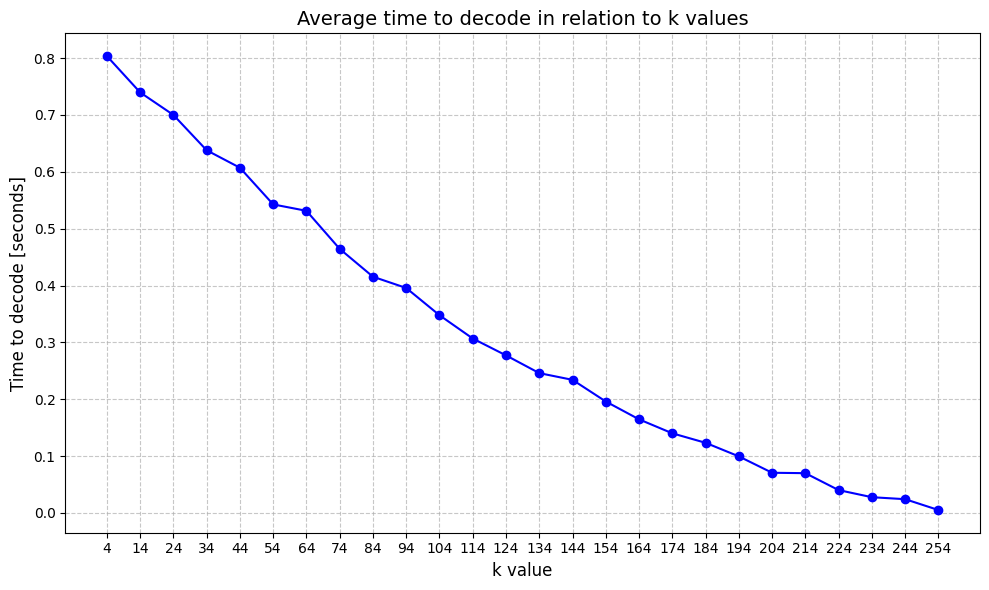

In [30]:
%matplotlib inline
# @title Show decoding times
from matplotlib import pyplot as plt

k_values = list(decoding_times.keys())
times = list(decoding_times.values())

plt.figure(figsize=(10, 6))
plt.plot(k_values, times, marker='o', linestyle='-', color='blue')

plt.title("Average time to decode in relation to k values", fontsize=14)
plt.xlabel("k value", fontsize=12)
plt.ylabel("Time to decode [seconds]", fontsize=12)

plt.grid(True, linestyle='--', alpha=0.7)

plt.xticks(k_values)

plt.tight_layout()
plt.show()